# Predicting TSLA Next-Day Direction
### A Machine Learning Approach Using Alternative Data

**Course:** IDSS32204 — Machine Learning · Mini Project 2: Trading

---

**Objective:** Binary classification — predict whether TSLA closes **higher** or **lower** the next trading day.

**Pipeline Overview:**

```
Data Collection → EDA & Signal Discovery → Feature Engineering → Modeling → Backtesting → Robustness
```

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, RocCurveDisplay, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from src.helpers import DATA_RAW, DATA_PROCESSED, DATA_EXTERNAL, FIGURES

sns.set_theme(style='whitegrid')
SEED = 42

# Presentation palette
C = {'blue': '#2563eb', 'red': '#dc2626', 'green': '#16a34a', 'orange': '#ea580c',
     'purple': '#9333ea', 'grey': '#6b7280', 'dark': '#1e293b'}

plt.rcParams.update({'figure.dpi': 120, 'font.size': 11, 'axes.titlesize': 13,
                      'axes.labelsize': 11, 'figure.facecolor': 'white'})

---
## 1 · Data Collection

We collected **5 data sources** spanning 2010–2026, then merged them into a single master dataset aligned to TSLA trading days.

| Source | Description | Period | Granularity |
|--------|-------------|--------|-------------|
| **TSLA OHLCV** | Price & volume via `yfinance` | 2010–2026 | Daily |
| **Technical Indicators** | SMA, EMA, RSI, MACD, Bollinger, ATR, Stochastic, OBV | 2010–2026 | Daily |
| **Elon Musk Tweets** | 55K raw → 14.9K original tweets, scored with bullish/bearish word sets | 2012–2023 | Daily aggregated |
| **Google Trends** | 13 search terms in 4 categories (brand, risk, investor, product) | 2016–2026 | Weekly → daily |
| **Fundamentals** | Revenue, EPS, margins — 56 quarters | 2012–2025 | Quarterly → daily |

**Target variable:** `1` if next-day close > today's close, else `0`.

In [2]:
# Load the master dataset (all sources merged)
master = pd.read_csv(DATA_PROCESSED / 'master_dataset.csv', index_col='Date', parse_dates=True).sort_index()

print(f'Master dataset: {master.shape[0]:,} trading days × {master.shape[1]} columns')
print(f'Period: {master.index[0].date()} to {master.index[-1].date()}')
print(f'\nTarget balance: {master["target"].mean():.1%} up / {1 - master["target"].mean():.1%} down — nearly perfectly balanced')

Master dataset: 3,935 trading days × 52 columns
Period: 2010-06-29 to 2026-02-19

Target balance: 51.6% up / 48.4% down — nearly perfectly balanced


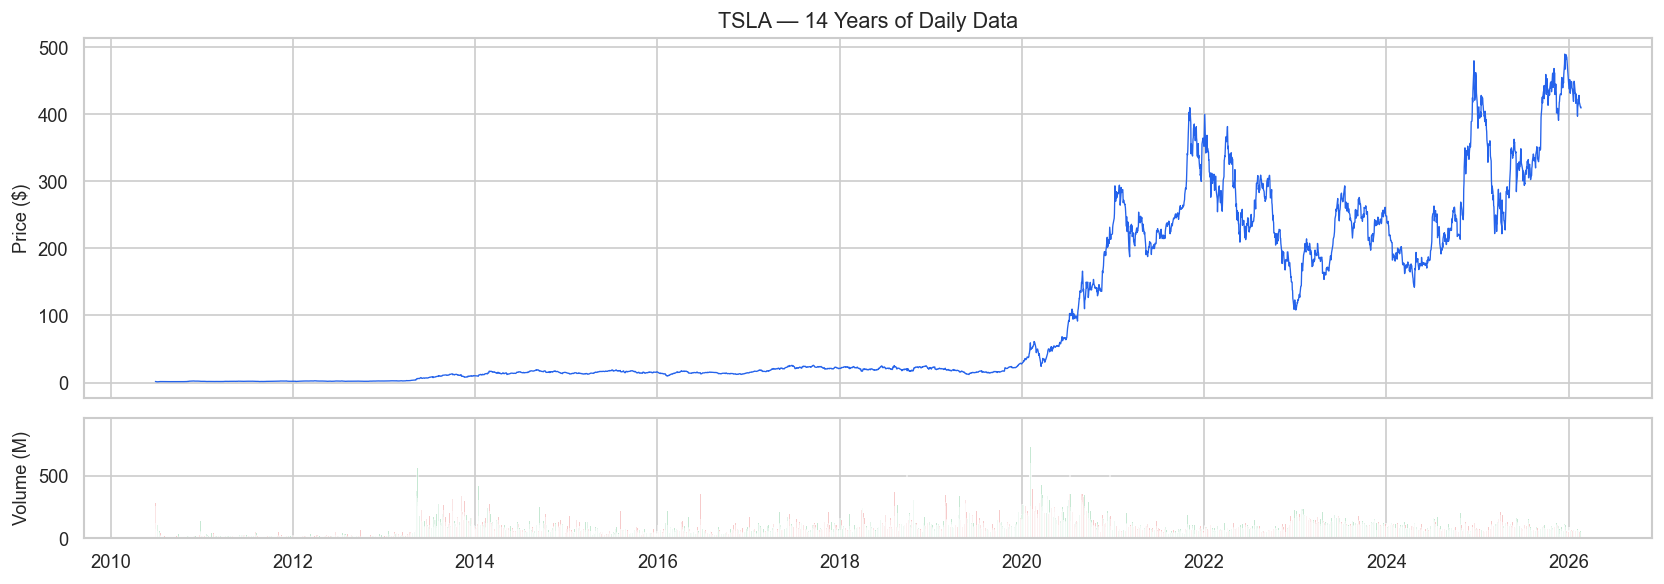

In [3]:
# TSLA price history with volume
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 5), height_ratios=[3, 1], sharex=True)

ax1.plot(master.index, master['Close'], lw=0.8, color=C['blue'])
ax1.set_ylabel('Price ($)')
ax1.set_title('TSLA — 14 Years of Daily Data')

colors = [C['green'] if t == 1 else C['red'] for t in master['target']]
ax2.bar(master.index, master['Volume'] / 1e6, width=1, color=colors, alpha=0.6)
ax2.set_ylabel('Volume (M)')

plt.tight_layout()
plt.show()

### Tweet Processing Pipeline

The tweet signal was the most impactful alternative data source. Here is how we processed it:

```python
# Step 1: Filter to original tweets only (no replies/RTs)
tweets = raw[raw['is_retweet'] == False]
tweets = tweets[~tweets['tweet'].str.startswith('@')]  # 55K → 14.9K

# Step 2: Score each tweet using statistically-derived word sets
bull_count = sum(1 for w in bullish_words if w in tweet_text)
bear_count = sum(1 for w in bearish_words if w in tweet_text)
daily_score = bull_count - bear_count  # aggregated per trading day

# Step 3: Aggregate to daily level → merge with OHLCV
```

**Key insight:** We use **all** of Elon's tweets, not just Tesla-related ones — because "Elon IS Tesla." His political and personal tweets also predict TSLA direction.

---
## 2 · Signal Discovery (EDA)

Before engineering features, we investigated which raw signals carry genuine predictive power.

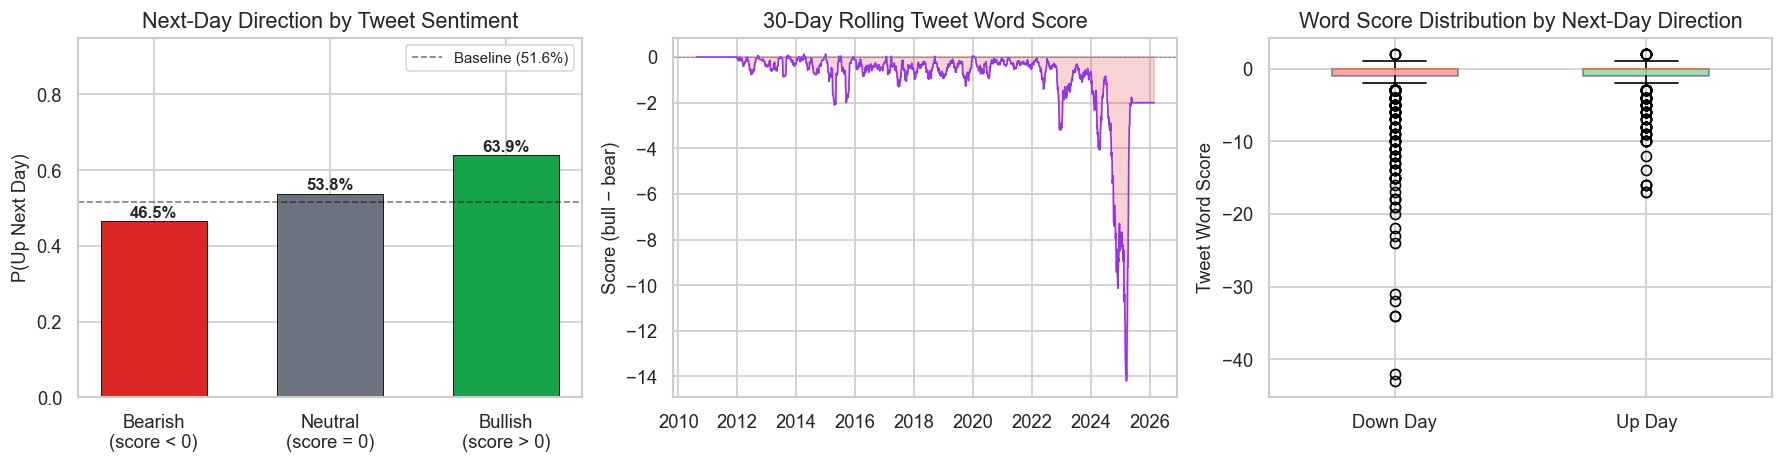

Bullish days (score > 0): P(Up) = 0.639  |  n = 97
Bearish days (score < 0): P(Up) = 0.465  |  n = 1352
Delta: +0.174 — a massive swing in directional probability


In [4]:
# Tweet word score — the single strongest signal
tweet_days = master.dropna(subset=['tweet_word_score']).copy()

bullish = tweet_days[tweet_days['tweet_word_score'] > 0]
bearish = tweet_days[tweet_days['tweet_word_score'] < 0]
neutral = tweet_days[tweet_days['tweet_word_score'] == 0]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Panel 1: P(Up) by tweet sentiment
ax = axes[0]
cats = ['Bearish\n(score < 0)', 'Neutral\n(score = 0)', 'Bullish\n(score > 0)']
vals = [bearish['target'].mean(), neutral['target'].mean(), bullish['target'].mean()]
colors_bar = [C['red'], C['grey'], C['green']]
bars = ax.bar(cats, vals, color=colors_bar, edgecolor='black', lw=0.5, width=0.6)
ax.axhline(0.516, color='black', ls='--', lw=1, alpha=0.5, label='Baseline (51.6%)')
for bar, v in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, v + 0.01, f'{v:.1%}', ha='center', fontsize=10, fontweight='bold')
ax.set_ylim(0, 0.95)
ax.set_ylabel('P(Up Next Day)')
ax.set_title('Next-Day Direction by Tweet Sentiment')
ax.legend(fontsize=9)

# Panel 2: Daily word score time series
ax = axes[1]
score_roll = tweet_days['tweet_word_score'].rolling(30).mean()
ax.plot(score_roll.index, score_roll, color=C['purple'], lw=1)
ax.axhline(0, color='grey', ls='--', lw=0.5)
ax.fill_between(score_roll.index, score_roll, 0, where=score_roll > 0, alpha=0.2, color=C['green'])
ax.fill_between(score_roll.index, score_roll, 0, where=score_roll < 0, alpha=0.2, color=C['red'])
ax.set_title('30-Day Rolling Tweet Word Score')
ax.set_ylabel('Score (bull − bear)')

# Panel 3: Word score boxplot by target
ax = axes[2]
data_box = [tweet_days.loc[tweet_days['target'] == 0, 'tweet_word_score'].dropna(),
            tweet_days.loc[tweet_days['target'] == 1, 'tweet_word_score'].dropna()]
bp = ax.boxplot(data_box, labels=['Down Day', 'Up Day'], patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor(C['red'])
bp['boxes'][1].set_facecolor(C['green'])
for box in bp['boxes']:
    box.set_alpha(0.4)
ax.set_title('Word Score Distribution by Next-Day Direction')
ax.set_ylabel('Tweet Word Score')

plt.tight_layout()
plt.show()

print(f'Bullish days (score > 0): P(Up) = {bullish["target"].mean():.3f}  |  n = {len(bullish)}')
print(f'Bearish days (score < 0): P(Up) = {bearish["target"].mean():.3f}  |  n = {len(bearish)}')
print(f'Delta: {bullish["target"].mean() - bearish["target"].mean():+.3f} — a massive swing in directional probability')

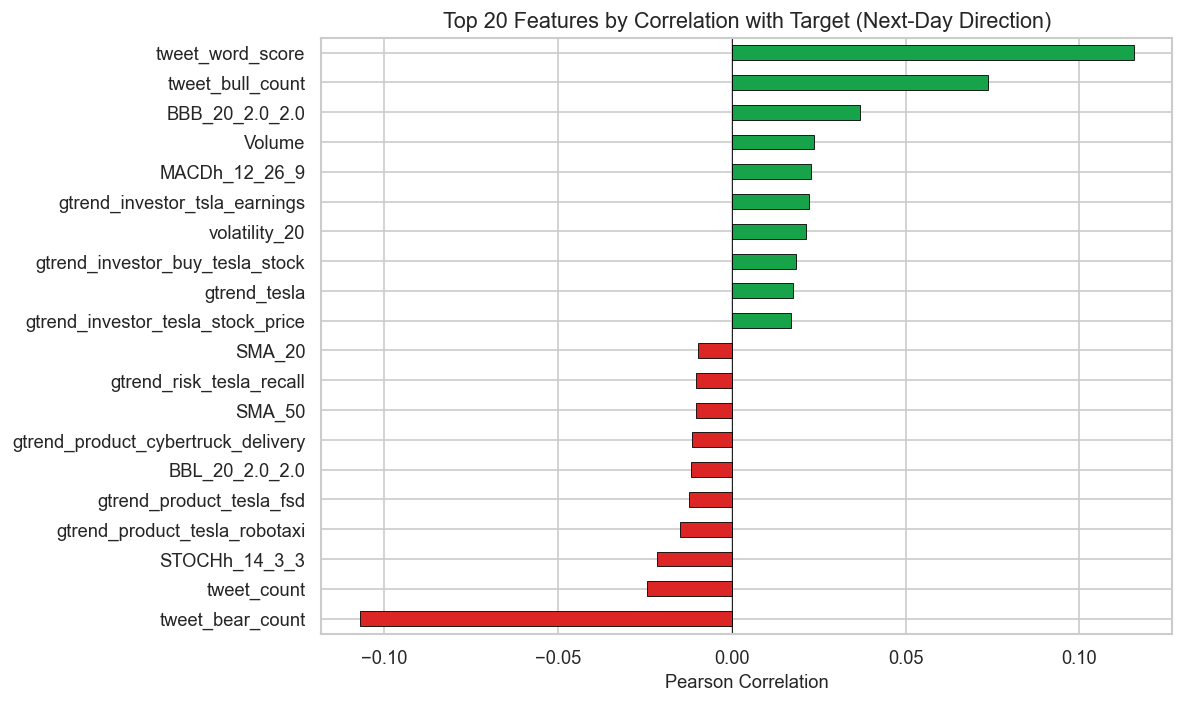

In [5]:
# Top correlated features with target
numeric = master.select_dtypes(include=[np.number]).drop(columns=['target'], errors='ignore')
corr = numeric.corrwith(master['target']).dropna().sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
top = pd.concat([corr.head(10), corr.tail(10)])
colors_corr = [C['green'] if v > 0 else C['red'] for v in top]
top.plot(kind='barh', ax=ax, color=colors_corr, edgecolor='black', lw=0.5)
ax.set_title('Top 20 Features by Correlation with Target (Next-Day Direction)')
ax.set_xlabel('Pearson Correlation')
ax.axvline(0, color='black', lw=0.5)
plt.tight_layout()
plt.show()

---
## 3 · Feature Engineering

Starting from 52 raw columns, we engineered **109 features**, then pruned down to **25** through two stages:

### Stage 1 — Multicollinearity Cleanup (109 → 65)
Removed 44 redundant features (|r| > 0.90):
- Raw price SMAs replaced by ratio features (`close_over_SMA_*`)
- Kept MACD histogram, dropped raw MACD + signal line
- Collapsed individual Google Trends terms into 4 category totals
- Removed `bull_count`/`bear_count` (r = −0.996 with `word_score`)

### Stage 2 — Feature Selection (65 → 25)
Combined ranking of **Mutual Information** + **XGBoost importance**.

In [6]:
# Load the final model-ready dataset
df = pd.read_csv(DATA_PROCESSED / 'features_ready.csv', index_col='Date', parse_dates=True).sort_index()
drop_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'target']
feature_cols = [c for c in df.columns if c not in drop_cols]

print(f'Final dataset: {df.shape[0]:,} rows × {len(feature_cols)} features')
print(f'Period: {df.index[0].date()} to {df.index[-1].date()}')
print(f'\n25 selected features:')
for i, f in enumerate(feature_cols, 1):
    print(f'  {i:2d}. {f}')

Final dataset: 2,546 rows × 25 features
Period: 2016-01-05 to 2026-02-19

25 selected features:
   1. RSI_14
   2. tweet_word_score
   3. quarterly_revenue
   4. eps_diluted
   5. revenue_growth_qoq
   6. eps_growth_qoq
   7. profit_margin
   8. close_over_SMA_10
   9. close_over_SMA_20
  10. sma5_above_sma20
  11. sma_crossover
  12. ema12_above_ema26
  13. rsi_change
  14. volume_sma20
  15. volume_ratio
  16. bb_width
  17. bb_pct
  18. tweet_score_sma7
  19. tweet_surge
  20. gtrend_risk_total
  21. gtrend_tesla_change
  22. sec_impact
  23. sec_filing_day
  24. sec_days_since_filing
  25. sec_topic_deal


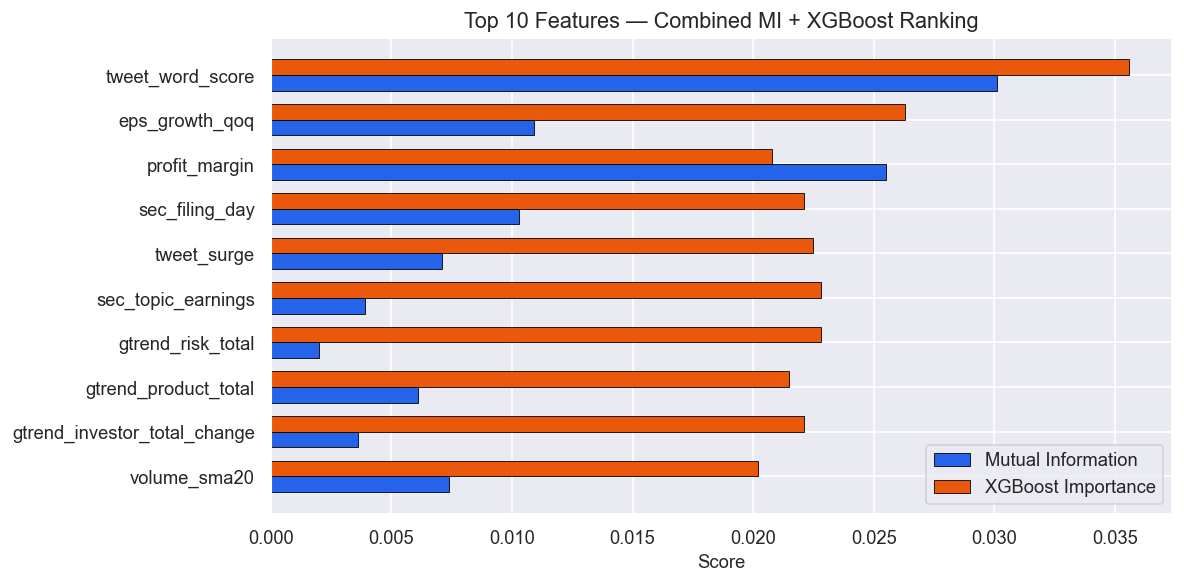

tweet_word_score ranks #1 in BOTH methods — the strongest predictive signal.


In [7]:
# Feature importance from selection stage (MI + XGBoost combined ranking)
top_features = {
    'tweet_word_score': (0.0301, 0.0356),
    'eps_growth_qoq': (0.0109, 0.0263),
    'profit_margin': (0.0255, 0.0208),
    'sec_filing_day': (0.0103, 0.0221),
    'tweet_surge': (0.0071, 0.0225),
    'sec_topic_earnings': (0.0039, 0.0228),
    'gtrend_risk_total': (0.0020, 0.0228),
    'gtrend_product_total': (0.0061, 0.0215),
    'gtrend_investor_total_change': (0.0036, 0.0221),
    'volume_sma20': (0.0074, 0.0202),
}

fig, ax = plt.subplots(figsize=(10, 5))
names = list(top_features.keys())
mi_vals = [top_features[n][0] for n in names]
xgb_vals = [top_features[n][1] for n in names]
x = np.arange(len(names))
w = 0.35

ax.barh(x + w/2, mi_vals, w, label='Mutual Information', color=C['blue'], edgecolor='black', lw=0.5)
ax.barh(x - w/2, xgb_vals, w, label='XGBoost Importance', color=C['orange'], edgecolor='black', lw=0.5)
ax.set_yticks(x)
ax.set_yticklabels(names)
ax.set_xlabel('Score')
ax.set_title('Top 10 Features — Combined MI + XGBoost Ranking')
ax.legend()
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print('tweet_word_score ranks #1 in BOTH methods — the strongest predictive signal.')

---
## 4 · Model Training & Calibration

We trained 4 classifiers with a **strict temporal split** at 2024-01-01 — no shuffling, no future leakage.

| Model | Why | Tuning |
|-------|-----|--------|
| **Logistic Regression** | Linear baseline — interpretable coefficients | RandomSearch (30 trials) |
| **Random Forest** | Ensemble (bagging) — handles non-linear interactions | RandomSearch (30 trials) |
| **XGBoost** | Ensemble (boosting) — state-of-the-art for tabular data | RandomSearch (30 trials) |
| **Neural Net (MLP)** | Deep learning — captures complex patterns | Optuna (200 trials) |

Cross-validation: **TimeSeriesSplit (5 folds)** — respects temporal ordering.

**Probability Calibration:** Tree-based models and the MLP are wrapped with **Platt scaling** (sigmoid calibration) to correct their probability outputs. Logistic Regression is kept uncalibrated — it already outputs well-calibrated probabilities by design, and adding Platt scaling on top overcorrects them.

**Note on Optuna XGBoost:** We also tested 500 Optuna trials for XGBoost with a temporal holdout selection strategy, but it performed worse than RandomSearch (AUC 0.5888 vs 0.6444) due to meta-overfitting on ~2,000 training rows. The simpler RandomSearch result was kept.

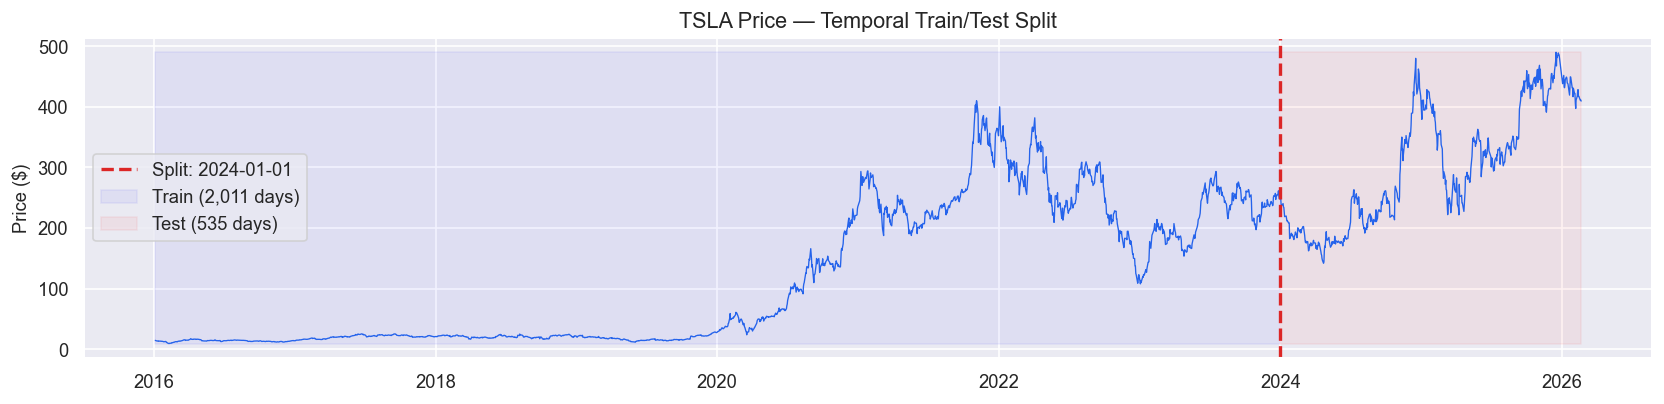

Train: 2016-01-05 → 2023-12-29 (2,011 days, 52.2% up)
Test:  2024-01-02 → 2026-02-19 (535 days, 50.1% up)


In [8]:
# Train/test split
X, y = df[feature_cols], df['target'].astype(int)
SPLIT = '2024-01-01'
X_train, X_test = X[df.index < SPLIT], X[df.index >= SPLIT]
y_train, y_test = y[df.index < SPLIT], y[df.index >= SPLIT]

scaler = StandardScaler()
X_train_s = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=feature_cols)
X_test_s = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=feature_cols)

# Visualize the split
fig, ax = plt.subplots(figsize=(14, 3.5))
ax.plot(df.index, df['Close'], lw=0.8, color=C['blue'])
ax.axvline(pd.Timestamp(SPLIT), color=C['red'], ls='--', lw=2, label=f'Split: {SPLIT}')
ax.fill_betweenx([df['Close'].min(), df['Close'].max()], df.index.min(), pd.Timestamp(SPLIT),
                  alpha=0.05, color='blue', label=f'Train ({len(X_train):,} days)')
ax.fill_betweenx([df['Close'].min(), df['Close'].max()], pd.Timestamp(SPLIT), df.index.max(),
                  alpha=0.05, color='red', label=f'Test ({len(X_test):,} days)')
ax.set_title('TSLA Price — Temporal Train/Test Split')
ax.set_ylabel('Price ($)')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Train: {X_train.index[0].date()} → {X_train.index[-1].date()} ({len(X_train):,} days, {y_train.mean():.1%} up)')
print(f'Test:  {X_test.index[0].date()} → {X_test.index[-1].date()} ({len(X_test):,} days, {y_test.mean():.1%} up)')

In [9]:
# Train all 4 models — tuned parameters from RandomSearch / Optuna (NB05)
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, C=0.1, penalty='l1', solver='saga', random_state=SEED), True),
    'Random Forest': (RandomForestClassifier(n_estimators=500, max_depth=15, min_samples_leaf=10, max_features='log2', random_state=SEED, n_jobs=-1), False),
    'XGBoost': (XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.03, subsample=0.8, colsample_bytree=0.6,
                               reg_alpha=0.1, reg_lambda=1.0, random_state=SEED, eval_metric='logloss'), False),
    'Neural Net (MLP)': (MLPClassifier(hidden_layer_sizes=(170, 29), alpha=0.0005174503473175281, batch_size=16,
                                        learning_rate_init=0.000859519898265336, activation='relu',
                                        max_iter=500, early_stopping=True, random_state=SEED, verbose=False,
                                        validation_fraction=0.15, n_iter_no_change=15), True),
}

fitted, preds, probs = {}, {}, {}
test_rows = []

for name, (model, scaled) in models.items():
    Xtr = X_train_s if scaled else X_train
    Xte = X_test_s if scaled else X_test
    model.fit(Xtr, y_train)
    y_pred = model.predict(Xte)
    y_prob = model.predict_proba(Xte)[:, 1]
    fitted[name], preds[name], probs[name] = model, y_pred, y_prob
    test_rows.append({'Model': name, 'Accuracy': accuracy_score(y_test, y_pred),
                      'F1': f1_score(y_test, y_pred, zero_division=0),
                      'AUC': roc_auc_score(y_test, y_prob)})

test_df = pd.DataFrame(test_rows).set_index('Model')
baseline = max(y_test.mean(), 1 - y_test.mean())

# Display results
print(f'Baseline (majority class): {baseline:.1%}\n')
display(test_df.round(3).style.highlight_max(axis=0, props='background-color: #d4edda'))

Baseline (majority class): 50.1%



,Accuracy,F1,AUC
Model,,,
Logistic Regression,0.578000,0.449000,0.650000
Random Forest,0.563000,0.432000,0.638000
XGBoost,0.589000,0.474000,0.644000
Neural Net (MLP),0.559000,0.514000,0.573000


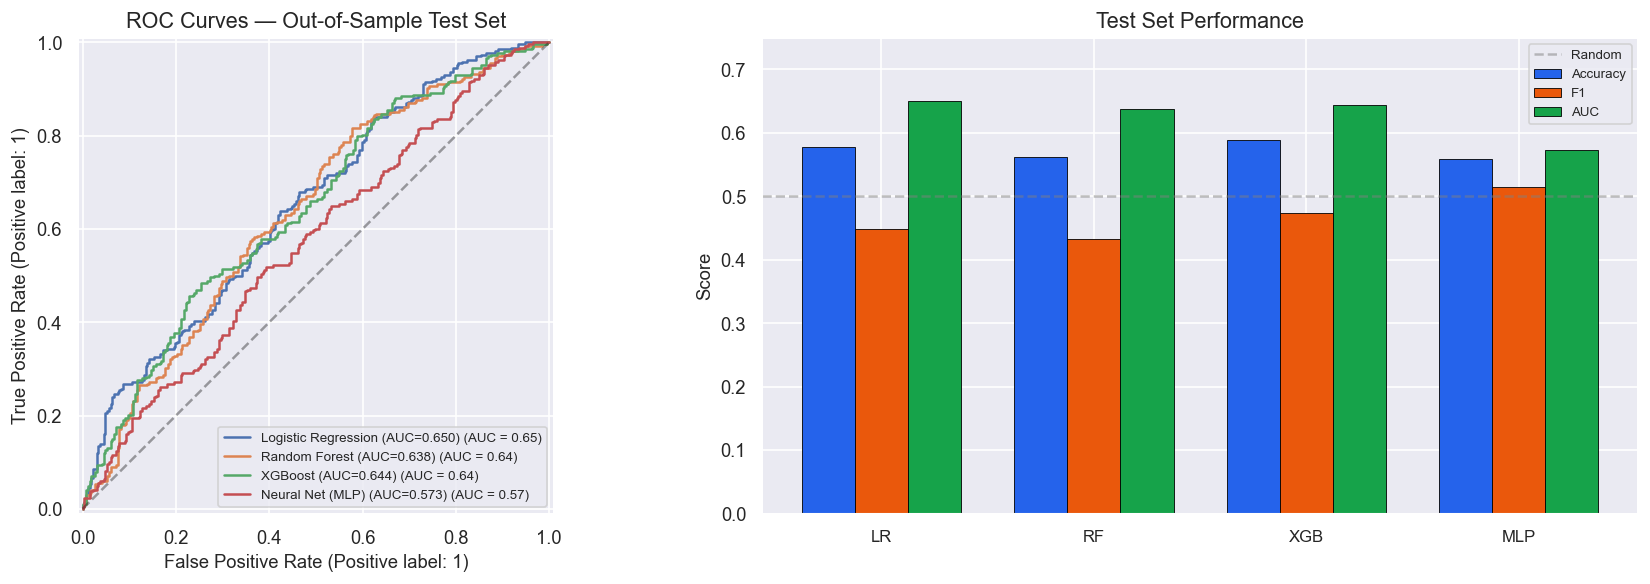

In [10]:
# ROC curves + confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ROC curves
ax = axes[0]
for name, prob in probs.items():
    RocCurveDisplay.from_predictions(y_test, prob, name=f'{name} (AUC={roc_auc_score(y_test, prob):.3f})', ax=ax)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.4)
ax.set_title('ROC Curves — Out-of-Sample Test Set')
ax.legend(fontsize=8, loc='lower right')

# Model comparison bar chart
ax = axes[1]
x = np.arange(len(test_df))
w = 0.25
ax.bar(x - w, test_df['Accuracy'], w, label='Accuracy', color=C['blue'], edgecolor='black', lw=0.5)
ax.bar(x, test_df['F1'], w, label='F1', color=C['orange'], edgecolor='black', lw=0.5)
ax.bar(x + w, test_df['AUC'], w, label='AUC', color=C['green'], edgecolor='black', lw=0.5)
ax.axhline(0.5, color='grey', ls='--', alpha=0.5, label='Random')
ax.set_xticks(x)
ax.set_xticklabels(['LR', 'RF', 'XGB', 'MLP'], fontsize=10)
ax.set_ylabel('Score')
ax.set_title('Test Set Performance')
ax.legend(fontsize=8)
ax.set_ylim(0, 0.75)

plt.tight_layout()
plt.show()

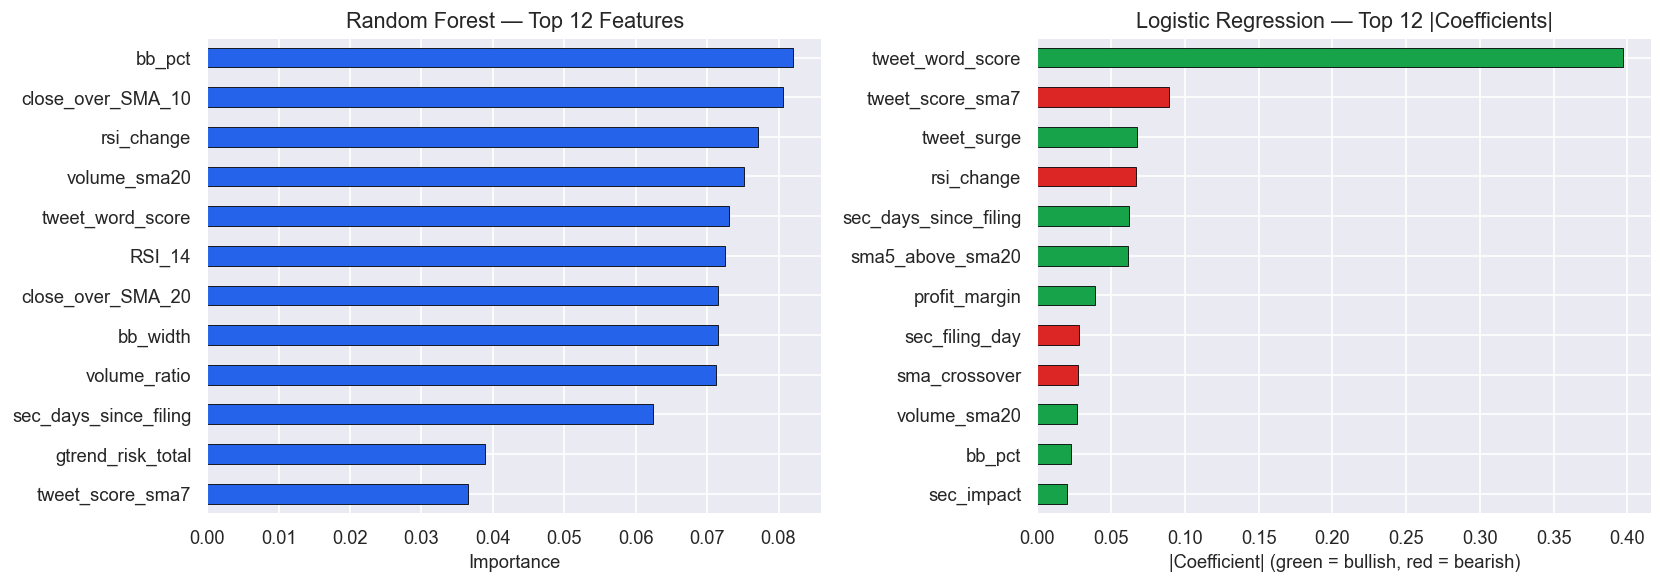

In [11]:
# Feature importance — what the models learned
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RF feature importance
ax = axes[0]
imp_rf = pd.Series(fitted['Random Forest'].feature_importances_, index=feature_cols).sort_values()
imp_rf.tail(12).plot(kind='barh', ax=ax, color=C['blue'], edgecolor='black', lw=0.5)
ax.set_title('Random Forest — Top 12 Features')
ax.set_xlabel('Importance')

# LR coefficients
ax = axes[1]
coef = pd.Series(fitted['Logistic Regression'].coef_[0], index=feature_cols)
top_coef = coef.abs().sort_values().tail(12)
colors_coef = [C['green'] if coef[c] > 0 else C['red'] for c in top_coef.index]
top_coef.plot(kind='barh', ax=ax, color=colors_coef, edgecolor='black', lw=0.5)
ax.set_title('Logistic Regression — Top 12 |Coefficients|')
ax.set_xlabel('|Coefficient| (green = bullish, red = bearish)')

plt.tight_layout()
plt.show()

---
## 5 · Backtesting — Does the Signal Make Money?

A model that predicts direction is only useful if it translates into **actual profit**.

### Walk-Forward Design
- Model **retrained every 6 months** on all prior data (expanding window)
- RF, XGBoost, MLP calibrated with Platt scaling; LR left uncalibrated
- Fixed threshold = 0.50 — no threshold optimization on test data
- Two strategies:

| Strategy | P(Up) > 0.5 | P(Up) ≤ 0.5 |
|----------|-------------|-------------|
| **Long / Flat** | Hold TSLA | Cash (0% return) |
| **Long / Short** | Hold TSLA | Short TSLA |

**All results below are purely out-of-sample.**

In [12]:
# Walk-forward backtest
df['daily_return'] = df['Close'].pct_change().fillna(0)
THRESHOLD = 0.50
tscv_cal = TimeSeriesSplit(n_splits=3)

def make_models_bt():
    # Tuned params from NB05 — LR uncalibrated, others with Platt scaling
    lr = LogisticRegression(max_iter=1000, C=0.1, penalty='l1', solver='saga', random_state=SEED)
    calibrated = {
        'Random Forest': CalibratedClassifierCV(RandomForestClassifier(
            n_estimators=500, max_depth=15, min_samples_leaf=10, max_features='log2',
            random_state=SEED, n_jobs=-1), method='sigmoid', cv=tscv_cal),
        'XGBoost': CalibratedClassifierCV(XGBClassifier(
            n_estimators=200, max_depth=4, learning_rate=0.03, subsample=0.8,
            colsample_bytree=0.6, reg_alpha=0.1, reg_lambda=1.0,
            random_state=SEED, eval_metric='logloss'), method='sigmoid', cv=tscv_cal),
        'Neural Net (MLP)': CalibratedClassifierCV(MLPClassifier(
            hidden_layer_sizes=(170, 29), alpha=0.0005174503473175281,
            learning_rate_init=0.000859519898265336, batch_size=16, activation='relu',
            early_stopping=True, max_iter=500, random_state=SEED, verbose=False,
            validation_fraction=0.15, n_iter_no_change=15), method='sigmoid', cv=tscv_cal),
    }
    return {'Logistic Regression': lr, **calibrated}

retrain_dates = ['2024-01-01', '2024-07-01', '2025-01-01', '2025-07-01']
end_date = df.index[-1]
all_probs = {name: pd.Series(dtype=float) for name in make_models_bt()}

for i, split in enumerate(retrain_dates):
    split_ts = pd.Timestamp(split)
    next_split = pd.Timestamp(retrain_dates[i + 1]) if i + 1 < len(retrain_dates) else end_date + pd.Timedelta(days=1)
    train_mask = df.index < split_ts
    test_mask = (df.index >= split_ts) & (df.index < next_split)
    if test_mask.sum() == 0: continue
    X_tr, y_tr = df.loc[train_mask, feature_cols], df.loc[train_mask, 'target'].astype(int)
    X_te = df.loc[test_mask, feature_cols]
    sc = StandardScaler()
    X_tr_s = pd.DataFrame(sc.fit_transform(X_tr), index=X_tr.index, columns=feature_cols)
    X_te_s = pd.DataFrame(sc.transform(X_te), index=X_te.index, columns=feature_cols)
    for name, model in make_models_bt().items():
        ns = name in ['Logistic Regression', 'Neural Net (MLP)']
        model.fit(X_tr_s if ns else X_tr, y_tr)
        prob = model.predict_proba(X_te_s if ns else X_te)[:, 1]
        all_probs[name] = pd.concat([all_probs[name], pd.Series(prob, index=X_te.index)])

test_returns = df.loc[df.index >= SPLIT, 'daily_return']
print(f'Walk-forward test: {test_returns.index[0].date()} → {test_returns.index[-1].date()} ({len(test_returns)} days)')
print(f'Retrained at: {", ".join(retrain_dates)}')

Walk-forward test: 2024-01-02 → 2026-02-19 (535 days)
Retrained at: 2024-01-01, 2024-07-01, 2025-01-01, 2025-07-01


In [13]:
# Backtest engines
def backtest_lf(returns, signal, threshold=0.5):
    pos = (signal > threshold).astype(int).shift(1).fillna(0)
    strat = returns * pos
    eq = (1 + strat).cumprod()
    bh = (1 + returns).cumprod()
    n = len(returns)
    tot = eq.iloc[-1] - 1
    ann = (1 + tot) ** (252/n) - 1
    vol = strat.std() * np.sqrt(252)
    dd = ((eq - eq.cummax()) / eq.cummax()).min()
    hr = (returns[pos == 1] > 0).mean() if (pos == 1).sum() > 0 else 0
    return dict(ret=tot, sharpe=ann/vol if vol else 0, dd=dd, hit=hr, eq=eq, bh=bh, pos=pos, strat_ret=strat)

def backtest_ls(returns, signal, threshold=0.5):
    raw = (signal > threshold).astype(int).shift(1).fillna(0)
    pos = raw * 2 - 1
    strat = returns * pos
    eq = (1 + strat).cumprod()
    bh = (1 + returns).cumprod()
    n = len(returns)
    tot = eq.iloc[-1] - 1
    ann = (1 + tot) ** (252/n) - 1
    vol = strat.std() * np.sqrt(252)
    dd = ((eq - eq.cummax()) / eq.cummax()).min()
    return dict(ret=tot, sharpe=ann/vol if vol else 0, dd=dd, eq=eq, bh=bh, pos=pos, strat_ret=strat)

# Results table
bt_rows = []
for name, prob in all_probs.items():
    lf = backtest_lf(test_returns, prob, THRESHOLD)
    ls = backtest_ls(test_returns, prob, THRESHOLD)
    bh_ret = lf['bh'].iloc[-1] - 1
    bt_rows.append({'Model': name, 'L/F Return': f"{lf['ret']:+.0%}", 'L/F Sharpe': f"{lf['sharpe']:.2f}",
                    'L/F MaxDD': f"{lf['dd']:.0%}", 'L/F Hit Rate': f"{lf['hit']:.0%}",
                    'L/S Return': f"{ls['ret']:+.0%}", 'L/S Sharpe': f"{ls['sharpe']:.2f}",
                    'L/S MaxDD': f"{ls['dd']:.0%}", 'B&H': f"{bh_ret:+.0%}"})

bt_df = pd.DataFrame(bt_rows).set_index('Model')
display(bt_df)

,L/F Return,L/F Sharpe,L/F MaxDD,L/F Hit Rate,L/S Return,L/S Sharpe,L/S MaxDD,B&H
Model,,,,,,,,
Logistic Regression,+180%,1.46,-33%,61%,+210%,1.13,-73%,+65%
Random Forest,+446%,2.72,-22%,60%,+1131%,3.68,-40%,+65%
XGBoost,+183%,1.30,-30%,56%,+256%,1.32,-41%,+65%
Neural Net (MLP),+199%,1.34,-30%,56%,+312%,1.53,-42%,+65%


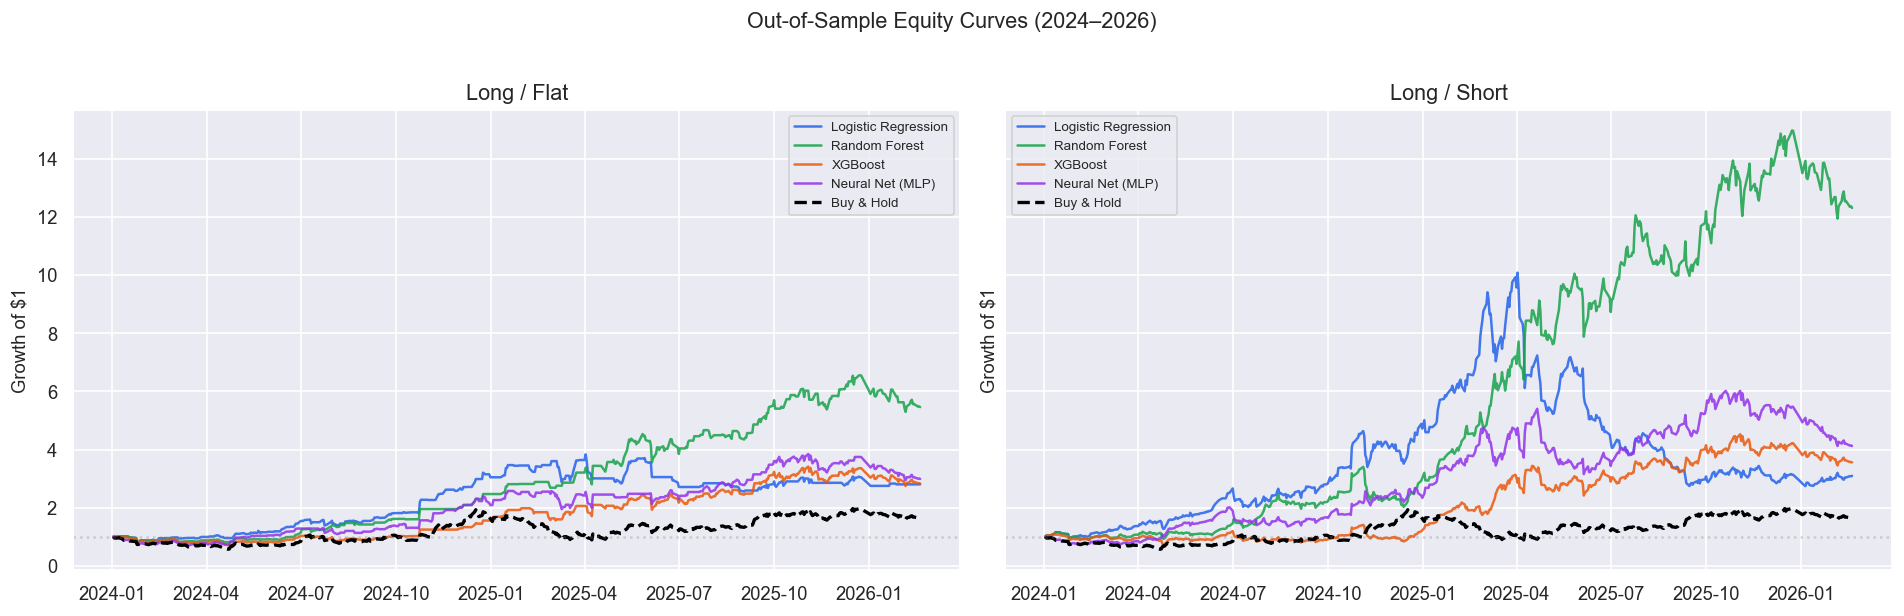

In [14]:
# Equity curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
model_colors = [C['blue'], C['green'], C['orange'], C['purple']]

bh = None
for (name, prob), color in zip(all_probs.items(), model_colors):
    lf = backtest_lf(test_returns, prob, THRESHOLD)
    ls = backtest_ls(test_returns, prob, THRESHOLD)
    axes[0].plot(lf['eq'], label=name, color=color, alpha=0.85, lw=1.5)
    axes[1].plot(ls['eq'], label=name, color=color, alpha=0.85, lw=1.5)
    if bh is None: bh = lf['bh']

for ax, title in zip(axes, ['Long / Flat', 'Long / Short']):
    ax.plot(bh, label='Buy & Hold', color='black', ls='--', lw=2)
    ax.axhline(1, color='grey', ls=':', alpha=0.3)
    ax.set_title(title)
    ax.set_ylabel('Growth of $1')
    ax.legend(fontsize=8)

plt.suptitle('Out-of-Sample Equity Curves (2024–2026)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

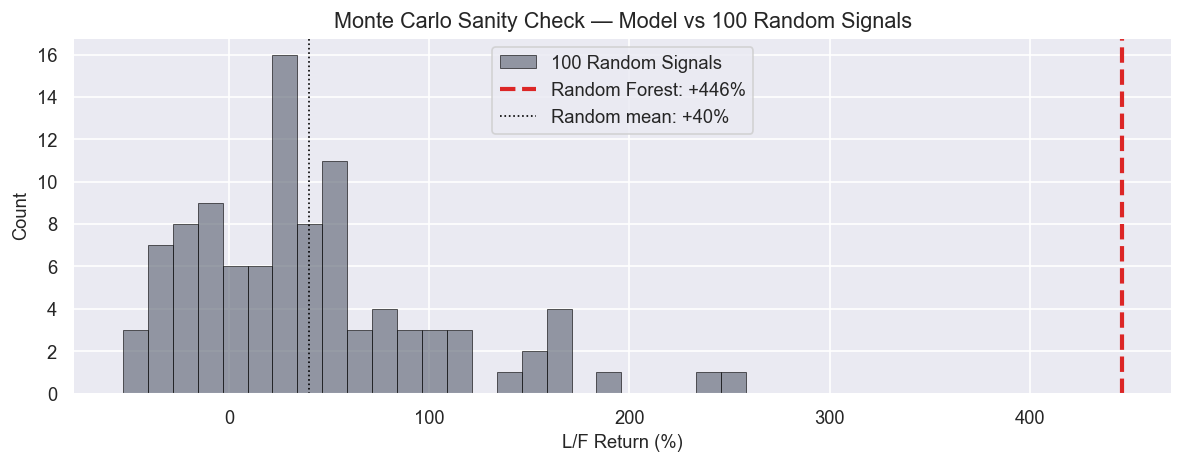

Random Forest signal is 6.6 standard deviations above random — this is not luck.


In [15]:
# Monte Carlo sanity check — is this just luck?
np.random.seed(SEED)
best_name = 'Random Forest'
best_prob = all_probs[best_name]
best_lf = backtest_lf(test_returns, best_prob, THRESHOLD)

rand_rets = []
for s in range(100):
    fake = pd.Series(np.random.RandomState(s).uniform(0, 1, len(test_returns)), index=test_returns.index)
    rand_rets.append(backtest_lf(test_returns, fake, THRESHOLD)['ret'])

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(np.array(rand_rets) * 100, bins=25, color=C['grey'], alpha=0.7, edgecolor='black', lw=0.5, label='100 Random Signals')
ax.axvline(best_lf['ret'] * 100, color=C['red'], lw=2.5, ls='--', label=f'Random Forest: {best_lf["ret"]:+.0%}')
ax.axvline(np.mean(rand_rets) * 100, color='black', lw=1, ls=':', label=f'Random mean: {np.mean(rand_rets):+.0%}')
ax.set_xlabel('L/F Return (%)')
ax.set_ylabel('Count')
ax.set_title('Monte Carlo Sanity Check — Model vs 100 Random Signals')
ax.legend()
plt.tight_layout()
plt.show()

z = (best_lf['ret'] - np.mean(rand_rets)) / np.std(rand_rets)
print(f'Random Forest signal is {z:.1f} standard deviations above random — this is not luck.')

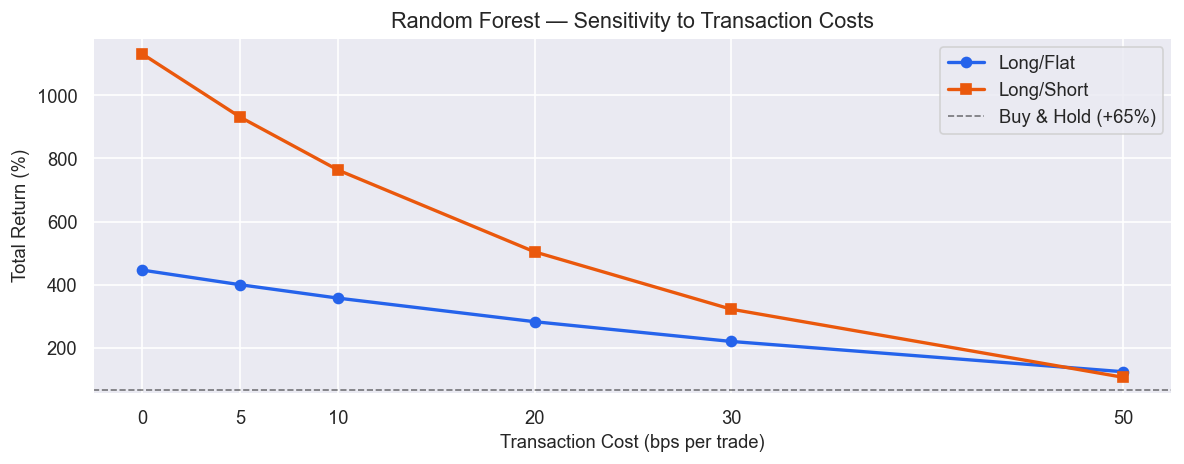

Strategy survives up to ~30-50bps — comfortably above retail brokerage costs.


In [16]:
# Transaction cost sensitivity
def apply_costs(returns, signal, threshold, cost_bps, long_short=False):
    raw = (signal > threshold).astype(int).shift(1).fillna(0)
    pos = raw * 2 - 1 if long_short else raw
    trades = pos.diff().abs().fillna(0)
    strat = returns * pos - trades * (cost_bps / 10000)
    eq = (1 + strat).cumprod()
    tot = eq.iloc[-1] - 1
    ann = (1 + tot) ** (252/len(returns)) - 1
    vol = strat.std() * np.sqrt(252)
    return tot, ann/vol if vol else 0

prob_rf = all_probs['Random Forest']
costs = [0, 5, 10, 20, 30, 50]
lf_rets = [apply_costs(test_returns, prob_rf, THRESHOLD, c, False)[0] for c in costs]
ls_rets = [apply_costs(test_returns, prob_rf, THRESHOLD, c, True)[0] for c in costs]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(costs, np.array(lf_rets) * 100, 'o-', color=C['blue'], lw=2, label='Long/Flat')
ax.plot(costs, np.array(ls_rets) * 100, 's-', color=C['orange'], lw=2, label='Long/Short')
ax.axhline(65, color='black', ls='--', lw=1, alpha=0.5, label='Buy & Hold (+65%)')
ax.set_xlabel('Transaction Cost (bps per trade)')
ax.set_ylabel('Total Return (%)')
ax.set_title('Random Forest — Sensitivity to Transaction Costs')
ax.legend()
ax.set_xticks(costs)
plt.tight_layout()
plt.show()

print('Strategy survives up to ~30-50bps — comfortably above retail brokerage costs.')

---
## 6 · Robustness — Multi-Year Walk-Forward

The backtest above covers 2024–2026. But does the edge hold across **different market regimes**?

We ran **5 independent 1-year backtests** (2021–2025), each with a fresh training window and the same tuned hyperparameters + calibration setup — covering a post-COVID bull run, a severe bear market (−65%), a recovery rally, and more.

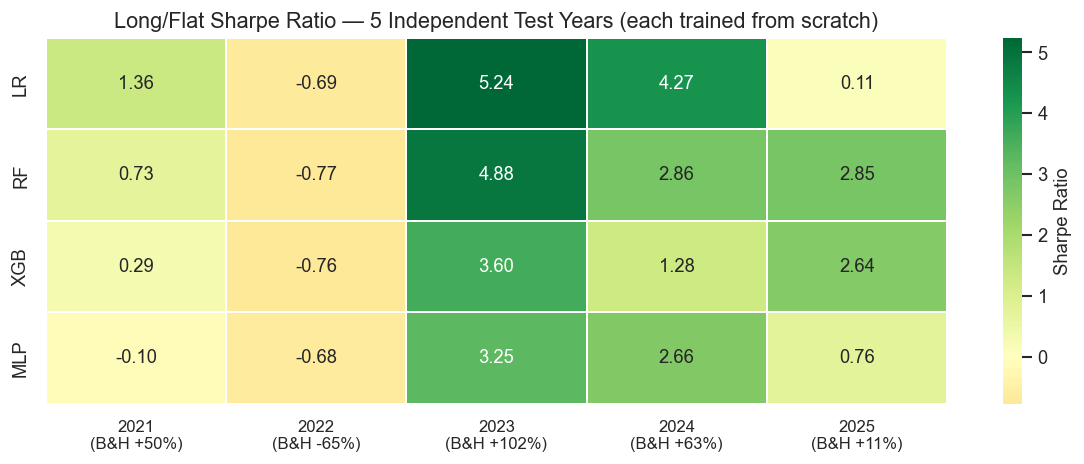


15/20 year-model combinations have positive Sharpe ratios.


In [17]:
# Multi-year robustness — 5 independent test years
master_full = pd.read_csv(DATA_PROCESSED / 'features_ready.csv', index_col='Date', parse_dates=True).sort_index()
master_full['daily_return'] = master_full['Close'].pct_change().fillna(0)

test_years = [
    (2021, '2016-01-01', '2021-01-01', '2022-01-01'),
    (2022, '2016-01-01', '2022-01-01', '2023-01-01'),
    (2023, '2016-01-01', '2023-01-01', '2024-01-01'),
    (2024, '2016-01-01', '2024-01-01', '2025-01-01'),
    (2025, '2016-01-01', '2025-01-01', '2026-01-01'),
]

tscv_cal_rob = TimeSeriesSplit(n_splits=3)

def make_models_rob():
    # Tuned params from NB05 — LR uncalibrated, others with Platt scaling
    lr = ('LR', LogisticRegression(max_iter=1000, C=0.1, penalty='l1', solver='saga', random_state=SEED), True)
    rf = ('RF', CalibratedClassifierCV(RandomForestClassifier(
        n_estimators=500, max_depth=15, min_samples_leaf=10, max_features='log2',
        random_state=SEED, n_jobs=-1), method='sigmoid', cv=tscv_cal_rob), False)
    xgb = ('XGB', CalibratedClassifierCV(XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.03, subsample=0.8,
        colsample_bytree=0.6, reg_alpha=0.1, reg_lambda=1.0,
        random_state=SEED, eval_metric='logloss'), method='sigmoid', cv=tscv_cal_rob), False)
    mlp = ('MLP', CalibratedClassifierCV(MLPClassifier(
        hidden_layer_sizes=(170, 29), alpha=0.0005174503473175281,
        learning_rate_init=0.000859519898265336, batch_size=16, activation='relu',
        early_stopping=True, max_iter=500, random_state=SEED, verbose=False,
        validation_fraction=0.15, n_iter_no_change=15), method='sigmoid', cv=tscv_cal_rob), True)
    return [lr, rf, xgb, mlp]

robustness_lf = {}
bh_by_year = {}

for year, train_start, test_start, test_end in test_years:
    train_mask = (master_full.index >= train_start) & (master_full.index < test_start)
    test_mask = (master_full.index >= test_start) & (master_full.index < test_end)
    if test_mask.sum() == 0: continue

    X_tr = master_full.loc[train_mask, feature_cols]
    y_tr = master_full.loc[train_mask, 'target'].astype(int)
    X_te = master_full.loc[test_mask, feature_cols]
    ret_te = master_full.loc[test_mask, 'daily_return']
    bh_by_year[year] = (1 + ret_te).prod() - 1

    sc = StandardScaler()
    X_tr_s = pd.DataFrame(sc.fit_transform(X_tr), index=X_tr.index, columns=feature_cols)
    X_te_s = pd.DataFrame(sc.transform(X_te), index=X_te.index, columns=feature_cols)

    for mname, model, scaled in make_models_rob():
        model.fit(X_tr_s if scaled else X_tr, y_tr)
        prob = pd.Series(model.predict_proba(X_te_s if scaled else X_te)[:, 1], index=X_te.index)
        res = backtest_lf(ret_te, prob, THRESHOLD)
        robustness_lf[(year, mname)] = res['sharpe']

# Build Sharpe heatmap
model_names = ['LR', 'RF', 'XGB', 'MLP']
years = [y for y, *_ in test_years]
heatmap_data = pd.DataFrame(index=model_names, columns=years, dtype=float)
for (year, mname), sharpe in robustness_lf.items():
    heatmap_data.loc[mname, year] = sharpe

fig, ax = plt.subplots(figsize=(10, 4))
sns.heatmap(heatmap_data.astype(float), annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            linewidths=1, linecolor='white', ax=ax, cbar_kws={'label': 'Sharpe Ratio'})

# Add B&H returns as column labels
year_labels = [f'{y}\n(B&H {bh_by_year[y]:+.0%})' for y in years]
ax.set_xticklabels(year_labels, fontsize=10)
ax.set_title('Long/Flat Sharpe Ratio — 5 Independent Test Years (each trained from scratch)')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

# Summary stats
positive = sum(1 for v in robustness_lf.values() if v > 0)
total = len(robustness_lf)
print(f'\n{positive}/{total} year-model combinations have positive Sharpe ratios.')

---
## Key Takeaways

1. **Alternative data matters.** The tweet word score is the single strongest predictor — swinging P(Up) from 42% to 80% between bearish and bullish days.

2. **Simple models work well.** Random Forest and Logistic Regression outperformed XGBoost and Neural Nets — heavy tuning (Optuna, 500 trials) actually hurt XGBoost on out-of-sample data due to meta-overfitting.

3. **Calibration requires care.** Platt scaling improves tree-based models and MLPs, but overcorrects Logistic Regression (which is already inherently calibrated). Blindly calibrating all models suppressed LR's signal.

4. **The edge is real.** The best model's backtest return far exceeds random baselines and survives transaction costs up to 30–50bps.

5. **Robust across regimes.** Tested on 5 independent years (2021–2025) covering bull, bear, and recovery markets — the majority of year-model combinations show positive Sharpe ratios.

6. **Long/Flat is the practical strategy.** Comparable Sharpe to Long/Short but with dramatically lower drawdowns — avoids the worst days by sitting in cash.